# Historical and future simulation of hailstorms in Australia

In [1]:
%cd git/hist_future_hail/

/home/561/tr2908/git/hist_future_hail


In [2]:
import sys
import xarray
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
from importlib import reload
import matplotlib.pyplot as plt
import modules.hist_fut_hail as hf
from dask.distributed import Client

## Settings

In [3]:
base_dir = '/g/data/up6/tr2908/hist_future_hail/'     # Data base directory.
hist_years = np.arange(1989, 2009)                    # Historical years.
fut_years = np.arange(2080, 2100)                     # Future years.
sims_dir = f'{base_dir}/WRF_v4.4/simulations/cities/' # Simulation directory.
data_dir = f'{base_dir}/xu_data'                      # Xu et al. data directory.

In [4]:
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:37177' processes=7 threads=28, memory=125.18 GiB>


## Environment

In [5]:
!module list

Currently Loaded Modulefiles:
 1) conda/analysis3-24.01(analysis:analysis3)   2) R/4.3.1   3) pbs  
>

In [6]:
!python --version

Python 3.10.13


## Temperature increases by year

We use a temperature-based framework to talk about future changes. To get mean near-surface air temperature we use the weighted mean (weighted by cosine of latitude) in the Xu et al SSP2-4.5 dataset. The following code can be used to generate this dataset after the lnd file for ssp245 has been wget and unzipped into /scratch.

In [7]:
# hf.mean_temp_per_year(infiles={'SSP2-4.5': '/scratch/w42/tr2908/xu_data/lnd.ssp245.*.nc',
#                                'SSP5-8.5': '/scratch/w42/tr2908/xu_data/lnd.ssp585.*.nc'},
#                       outfile=f'{data_dir}/mean_temperature_by_year.nc')

In [8]:
mean_temps = xarray.open_dataset(f'{data_dir}/mean_temperature_by_year.nc')

The reference temperature of 13.6 C is the mean temperature 1850-1900, annual using [CMIP6 35-model ensemble](https://interactive-atlas.ipcc.ch/permalink/Gzfztqvg).

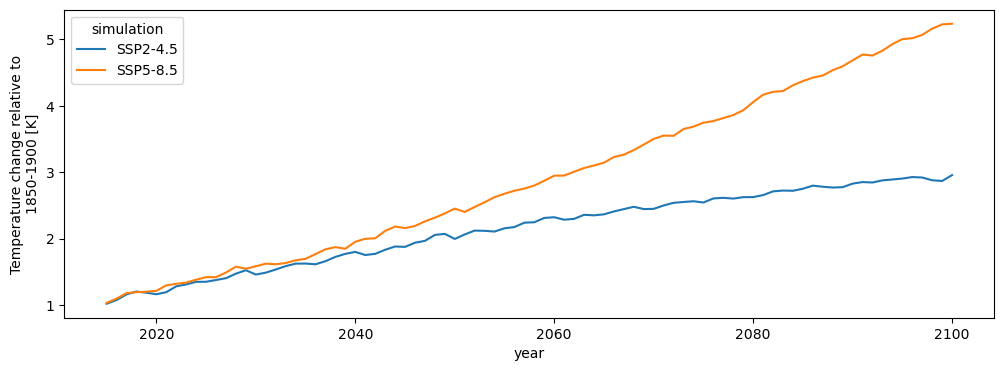

In [9]:
reference_temp = (13.6 + 273.15) # Mean temperature 1850-1990 using CMIP6 ensemble, annual, 35 models (https://interactive-atlas.ipcc.ch/regional-information#eyJ0eXBlIjoiQVRMQVMiLCJjb21tb25zIjp7ImxhdCI6MTc0MTAxMCwibG5nIjotNTU4MzgyNSwiem9vbSI6MywicHJvaiI6IkVQU0c6NTQwMzAiLCJtb2RlIjoiY29tcGxldGVfYXRsYXMifSwicHJpbWFyeSI6eyJzY2VuYXJpbyI6Imhpc3RvcmljYWwiLCJwZXJpb2QiOiJwcmVJbmR1c3RyaWFsIiwic2Vhc29uIjoieWVhciIsImRhdGFzZXQiOiJIQ01JUDYiLCJ2YXJpYWJsZSI6InRhcyIsInZhbHVlVHlwZSI6IlZBTFVFIiwiaGF0Y2hpbmciOiJTSU1QTEUiLCJyZWdpb25TZXQiOiJhcjYiLCJiYXNlbGluZSI6InByZUluZHVzdHJpYWwiLCJyZWdpb25zU2VsZWN0ZWQiOls0NywxLDMsNCw1LDIsMCw1MCw4LDcsNiw0NiwyOCwxNiwxNywxOCwxOSwzMiwyOSwzMCwzNCwzMywzNSwzMSwyMCwyMSwzNiwyMiw1MSwxMSwxMCw5LDQ4LDQ5LDEzLDE0LDI1LDI2LDI0LDUzLDM3LDU0LDM4LDM5LDQwLDQxLDQyLDU3LDEyLDUyLDIzLDU1LDI3LDU2LDQzLDE1LDQ1LDQ0XX0sInBsb3QiOnsiYWN0aXZlVGFiIjoidGFibGUiLCJzaG93aW5nIjp0cnVlLCJtYXNrIjoibm9uZSIsInNjYXR0ZXJZTWFnIjoiVkFMVUUiLCJzY2F0dGVyWVZhciI6InRhcyJ9fQ==)
mean_temps['change'] = mean_temps.tas - reference_temp
mean_temps.change.attrs = {'long_name': 'Temperature change relative to 1850-1900', 'units': 'K'}
mean_temps.change.plot(figsize=(12,4), hue='simulation')
plt.show()

In [10]:
mean_temps = mean_temps.sel(simulation='SSP2-4.5')
cross_2 = mean_temps.where(mean_temps.change > 2, drop=True).year.min().values
cross_25 = mean_temps.where(mean_temps.change > 2.5, drop=True).year.min().values
mean_change_fut_years = mean_temps.sel(year=slice(fut_years.min(), fut_years.max()+1)).change.mean().values
print(f'Mean temperature change over the future years selected here ({fut_years.min()}-{fut_years.max()+1}) is {np.round(mean_change_fut_years, 2)} K over pre-industrial.')
print(f'Mean temperature crosses 2 degrees over pre-industrial in {cross_2} (window is {cross_2-10}-{cross_2+10}).')
print(f'Mean temperature crosses 2.5 degrees over pre-industrial in {cross_25} (window is {cross_25-10}-{cross_25+10}).')

Mean temperature change over the future years selected here (2080-2100) is 2.81 K over pre-industrial.
Mean temperature crosses 2 degrees over pre-industrial in 2048 (window is 2038-2058).
Mean temperature crosses 2.5 degrees over pre-industrial in 2071 (window is 2061-2081).


In [11]:
d = xarray.open_dataset('/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/cities/hist/1989-1990/WRF/basic_params_d03_1989-09-30_00:00:00.nc')

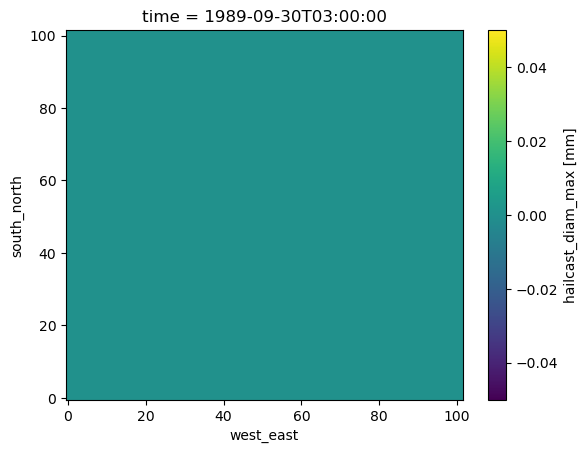

In [29]:
d.hailcast_diam_max.isel(time=3).plot()

## Changes by city

In [7]:
domains = {'Perth': 3, 
           'Melbourne': 5,
           'Brisbane': 6,
           'Sydney_Canberra': 7}

variables = ['hailcast_diam_max']
nonzero_vars = ['hailcast_diam_max']

for domain, d in domains.items():
    print(f'Processing d0{d}...')
    hist = xarray.open_mfdataset(f'/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/cities/hist/*/WRF/basic*d0{d}*.nc', parallel=True)
    futu = xarray.open_mfdataset(f'/g/data/up6/tr2908/hist_future_hail/WRF_v4.4/simulations/cities/ssp245/*/WRF/basic*d0{d}*.nc', parallel=True)
    break

Processing d03...


In [8]:
hist

<xarray.Dataset> Size: 3TB
Dimensions:            (time: 72840, south_north: 102, west_east: 102,
                        bottom_top: 79)
Coordinates:
  * time               (time) datetime64[ns] 583kB 1989-09-30 ... 2009-02-28T...
  * south_north        (south_north) int64 816B 0 1 2 3 4 5 ... 97 98 99 100 101
  * west_east          (west_east) int64 816B 0 1 2 3 4 5 ... 97 98 99 100 101
  * bottom_top         (bottom_top) int64 632B 0 1 2 3 4 5 ... 73 74 75 76 77 78
Data variables: (12/17)
    longitude          (time, south_north, west_east) float32 3GB dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    latitude           (time, south_north, west_east) float32 3GB dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    pressure           (time, bottom_top, south_north, west_east) float32 239GB dask.array<chunksize=(12, 40, 51, 51), meta=np.ndarray>
    temperature        (time, bottom_top, south_north, west_east) float32 239GB dask.array<chunksize=(12, 40, 51, 51), meta=np.ndarray>
    rh                 (time, bottom_top, south_north, west_east) float32 239GB dask.array<chunksize=(12, 40, 51, 51), meta=np.ndarray>
    u                  (time, bottom_top, south_north, west_east) float32 239GB dask.array<chunksize=(12, 40, 51, 51), meta=np.ndarray>
    ...                 ...
    updraft_helicity   (time, south_north, west_east) float32 3GB dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    slp                (time, south_north, west_east) float32 3GB dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    ter                (time, south_north, west_east) float32 3GB dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    td                 (time, bottom_top, south_north, west_east) float32 239GB dask.array<chunksize=(12, 40, 51, 51), meta=np.ndarray>
    hailcast_diam_max  (time, south_north, west_east) float32 3GB dask.array<chunksize=(24, 102, 102), meta=np.ndarray>
    specific_humidity  (time, bottom_top, south_north, west_east) float32 239GB dask.array<chunksize=(12, 40, 51, 51), meta=np.ndarray>
Attributes:
    projection:  RotatedLatLon(stand_lon=44.79999923706055, moad_cen_lat=-33....

In [ ]:
%%time
stats = hf.conv_stats()

In [ ]:
h_file = '/g/data/up6/tr2908/hist_future_hail/distributions/brisbane_max_hail_diam_hist.feather'
f_file = '/g/data/up6/tr2908/hist_future_hail/distributions/brisbane_max_hail_diam_ssp245.feather'

h = stats.hailcast_diam_max_quantile.isel(city=0, sim=0, quantile=4).to_dataframe().dropna().reset_index().to_feather(h_file, compression='lz4')
f = stats.hailcast_diam_max_quantile.isel(city=0, sim=1, quantile=4).to_dataframe().dropna().reset_index().to_feather(f_file, compression='lz4')

In [ ]:
h

In [ ]:
from shapely.geometry import Polygon
from geopandas import gpd

polygons = []
for city in stats.city.values:
    lats = stats.sel(city=city).latitude.values
    lons = stats.sel(city=city).longitude.values
    bbox = Polygon([(np.nanmin(lons), np.nanmin(lats)),
                    (np.nanmax(lons), np.nanmin(lats)),
                    (np.nanmax(lons), np.nanmax(lats)),
                    (np.nanmin(lons), np.nanmax(lats))])
    polygons.append(bbox)
polygons = gpd.GeoSeries(polygons).boundary

In [ ]:
plt.show()                                                              # Start the plotting engine.
plt.rcParams['font.size'] = 12                                          # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False                        # Don't use offsets in plots.

In [ ]:
hail_clim.hail_proxy.attrs['long_name'] = 'Proxy-derived mean annual hail-prone days in ERA5 (1979-2021)'
hf.plot_map(hail_clim.hail_proxy, cmap='Spectral_r', country='Australia', title='', 
            cbar_shrink=0.4, cbar_pad=0.015, axis_off=True, figsize=(12,8),
            cbar_inset=True, cbar_orientation='horizontal', nan_colour='white', pts=hf.cities,
            grid=False, polygons=polygons, polygon_colour='black', file='climatology_and_domains.pdf')

In [ ]:
import scipy.stats as scs

In [ ]:
def plot_dist_comparison(dat, variables, varnames, maskvar=None, mask=None, quantiles=None,
                         figsize=(12,6), xlims=None, log=None, file=None, invert=False, 
                         palettes=None, hspace=0.7, wspace=0.5, showfliers=False):
    """
    Plot a distribution comparison between simulations.

    Arguments:
        dat: Data to use for the plots.
        variables: The variables to plot for (one row per variable).
        quantiles: If required, the quantile to select.
        varnames: Pretty-print name of variables for axis labels.
        figsize: Figure width, height.
        xlims: Limit x axis extent?
        log: X axis in log scale?
        invert: Invert the plot row/columns?
        palettes: Palette for each variable?
        hspace, wspace: grid spec spacings.
        showfliers: Show outliers in plots?
    """

    fig, axs = plt.subplots(ncols=len(dat.city.values), nrows=len(variables), figsize=figsize, gridspec_kw={'hspace': hspace,
                                                                                                            'wspace': wspace})
    
    for v, var in enumerate(variables):
        for i, city in enumerate(dat.city.values):

            ax = axs[v, i]
            if invert:
                ax = axs[i, v]
            
            if quantiles[v] is not None:
                d = dat.sel(city=city, quantile=quantiles[v])[variables[v]]
            else:
                d = dat.sel(city=city)[variables[v]]
                assert not 'quantile' in d.dims, 'Quantile needs to be specified for this variable.'

            hist = d.sel(sim='Historical').values
            fut = d.sel(sim='+2.8 C').values
            ttest_res, pval = scs.ttest_ind(hist[~np.isnan(hist)], 
                                            fut[~np.isnan(fut)], equal_var=False)
            sig = pval < 0.05
            print(f'{city} {var} - sig diff? {sig}')
            
            if maskvar is not None:
                if mask[v] == True:
                    m = dat.sel(city=city)[maskvar]
                    d = d.where(m > 0)

            palette = None
            if palettes is not None:
                palette = palettes[v]
            
            sns.boxplot(data=d.to_dataframe(), x=variables[v], hue='sim', fill='sim', 
                        y='sim', ax=ax, showfliers=showfliers, palette=palette, showmeans=True,
                        meanprops={'marker': 'o',
                                   'markerfacecolor': 'white', 
                                   'markeredgecolor': 'black',
                                   'markersize': 10})

            if v == 0 or invert:
                ax.set_title(city)

            if (not invert) or (i == len(dat.city.values)-1):
                ax.set_xlabel(varnames[v])
            else:
                ax.set_xlabel('')

            if not xlims is None:
                ax.set_xlim(xlims[v])

            if not log is None:
                if log[v]:
                    ax.set_xscale('log')

            if invert and v != 0:
                ax.set_yticks([])

            ax.set_ylabel('')
    
    if not file is None:
        plt.savefig(fname=file, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        plt.show()

In [ ]:
d = stats.hailcast_diam_max_mean.resample(time='1D').max()
d = d.where(np.isnan(d), other=1)
d = d.resample(time='1YE').sum()
d = d.where(d > 0)
d = d.rename({'time': 'year'})
stats['hail_occurrences'] = d.load()

In [ ]:
a = stats.sel(quantile=1, city='Brisbane').mixed_100_cape_quantile.isel(sim=0).dropna('time')
b = stats.sel(quantile=1, city='Brisbane').mixed_100_cape_quantile.isel(sim=1).dropna('time')

In [ ]:
stats['quantile'].values

In [ ]:
plt.rcParams['font.size'] = 14
plot_dist_comparison(dat=stats, 
                     variables=['hailcast_diam_max_quantile', 
                                'hail_occurrences'], 
                     varnames=['Median hail size [mm]', 
                               'Annual hail days'],
                     quantiles=[0.5, None], 
                     log=[False, False],
                     figsize=(20, 3.5),
                     file='hail_changes.pdf',
                     palettes=['Reds', 'Blues'],
                     showfliers=True)

In [ ]:
plot_dist_comparison(dat=stats, #maskvar='hailcast_diam_max_mean',
                     variables=['mixed_100_cape_quantile', 
                                'mixed_100_cin_quantile',
                                'shear_magnitude_quantile', 
                                'melting_level_mean'], 
                     varnames=['Max CAPE [J kg$^{-1}$', 
                               'Min CIN [J kg$^{-1}$', 
                               'Max S06 [m s$^{-1}$]', 
                               'Mean MLH [m]'],
                     #mask=[True, True, True, True],
                     quantiles=[1, 0, 1, None], 
                     log=[False, False, False, False],
                     figsize=(15, 8), invert=True,
                     palettes=['PuRd', 'Greens', 'Greys', 'Oranges'],
                     wspace=0.15, showfliers=True,
                     file='ing_changes.pdf')

**Still need to ensure that all times are sorted in order!**

In [ ]:
min_times = np.inf
for city in dat:
    for sim in dat[city]:
        if dat[city][sim].Time.size < min_times:
            min_times = dat[city][sim].Time.size
            
# Subset to the first min_times times.
for city in dat:
    for sim in dat[city]:
        dat[city][sim] = dat[city][sim].isel(Time=slice(0, min_times))

In [ ]:
dat.keys()

In [ ]:
max_hail = []
#for city in dat:
for sim in dat['Brisbnane']:
    max_hail.append(dat['Brisbnane'][sim].HAILCAST_DIAM_MAX.max(['south_north', 'west_east']))

In [ ]:
max_hail = xarray.combine_nested(max_hail, concat_dim='simulation')

In [ ]:
print(max_hail.where(max_hail > 20).isel(simulation=0).count().values)
print(max_hail.where(max_hail > 20).isel(simulation=0).mean().values)

In [ ]:
print(max_hail.where(max_hail > 20).isel(simulation=1).count().values)
print(max_hail.where(max_hail > 20).isel(simulation=1).mean().values)

In [ ]:
d = f'{base_dir}/WRF_v4.4/simulations/hist/1989-1990/WRF'
print(d)

In [ ]:
perth = xarray.open_mfdataset(f'{d}/wrfout_d03_*', parallel=True, combine='nested', concat_dim='Time')
melb = xarray.open_mfdataset(f'{d}/wrfout_d05_*', parallel=True, combine='nested', concat_dim='Time')
bris = xarray.open_mfdataset(f'{d}/wrfout_d06_*', parallel=True, combine='nested', concat_dim='Time')
cbr_syd = xarray.open_mfdataset(f'{d}/wrfout_d07_*', parallel=True, combine='nested', concat_dim='Time')

In [ ]:
perth

In [ ]:
def plot_time(doms, titles=None, t=3, f='', pts=None, nrow=1, ncol=4, figsize=(12,4)):
    assert ncol * nrow >= len(doms), 'Insufficient rows/columns.'
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, nrows=nrow, ncols=ncol, figsize=figsize)
    
    for i, d in enumerate(doms):
        x = d.isel(Time=t).XLONG
        y = d.isel(Time=t).XLAT
        z = d.isel(Time=t)[f]

        ax.flat[i].pcolormesh(x, y, z, transform=ccrs.PlateCarree())
        ax.flat[i].coastlines(color='blue')
    
        if not titles is None:
            ax.flat[i].set_title(titles[i])
    
        # Add optional points.
        if not pts is None:
            for j in pts[i].keys():
                ax.flat[i].scatter(pts[i][j][0], pts[i][j][1], color='red')                          

In [ ]:
plot_time(doms=[perth, melb, cbr_syd, bris], 
          titles=['Perth', 'Melbourne', 'Canberra + Sydney', 'Brisbane'],
          f='TSK',
          pts=[{x: hf.cities[x] for x in ['Perth']},
               {x: hf.cities[x] for x in ['Melbourne']},
               {x: hf.cities[x] for x in ['Canberra', 'Sydney']},
               {x: hf.cities[x] for x in ['Brisbane']}])

In [ ]:
perth.isel(Time=0)